In [1]:
import os
import sys
import glob
import yaml
import pickle
import random

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path

from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, LabelEncoder

import wandb
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.utilities.seed import seed_everything

## config

In [2]:
# config
with open('config.yaml') as f:
    config = yaml.safe_load(f)

# globals variable
SEED = config['globals']['seed']
MAX_EPOCHS = config['globals']['max_epochs']
N_SPLITS = config['globals']['n_splits']
USE_FOLDS = config['globals']['use_folds']
DEBUG = config['globals']['debug']
EXP_MESSAGE = config['globals']['exp_message']
NOTES = config['globals']['notes']
MODEL_SAVE = config['globals']['model_save']
ONLY_PRED = config['globals']['only_pred']
PRETRAINED = config['globals']['pretrained']
PRETRAINED_PATH = config['globals']['pretrained_path']
EXP_NAME = str(Path().resolve()).split('/')[-1]

# seed
seed_everything(SEED)

Global seed set to 1996


1996

In [3]:
EXP_NAME

'exp027'

In [4]:
!wandb login 1bb2d0449c11d8b987e25c38b9d8dda176310fb6

wandb: Appending key for api.wandb.ai to your netrc file: /home/user/.netrc


## read data

In [5]:
# waypointを補正したdataset
root_dir = Path('../../input/')
with open(root_dir/'2kaido_wifi_dataset_v2/train_20000_7.pkl', 'rb') as f:
  train_df = pickle.load(f)

with open(root_dir/'2kaido_wifi_dataset_v2/test_20000_7.pkl', 'rb') as f:
  test_df = pickle.load(f)

sub_df = pd.read_csv(root_dir/'indoor-location-navigation/sample_submission.csv', index_col=0)

In [6]:

train_df = train_df.rename(columns={'wp_tmestamp':'timestamp', 'path_id':'path'})
test_df = test_df.rename(columns={'wp_tmestamp':'timestamp', 'path_id':'path'})

train_df = train_df.astype({'timestamp':int,'x': np.float32, 'y': np.float32, 'floor':np.float32, 'ix':np.float32, 'iy':np.float32})
test_df = test_df.astype({'timestamp':int})

In [7]:
# training target features
NUM_FEATS = 80
BSSID_FEATS = [f'bssid_{i}' for i in range(NUM_FEATS)]
RSSI_FEATS  = [f'rssi_{i}' for i in range(NUM_FEATS)]
TIMEDIFF_FEATS  = [f'timediff_{i}' for i in range(NUM_FEATS)]

In [8]:
# timediffをカテゴリ化したいのでbinにする
max_timediff = 20000
delta = 500
split = int(max_timediff / delta) + 1  # +1は欠損値分
for col in TIMEDIFF_FEATS:
    train_df.loc[:, col].fillna(999, inplace=True)
    test_df.loc[:, col].fillna(999, inplace=True)
    train_df.loc[:, f'{col}'] = pd.cut(train_df.loc[:, col], split, labels=[str(i) for i in range(split)])
    test_df.loc[:, f'{col}'] = pd.cut(test_df.loc[:, col], split, labels=[str(i) for i in range(split)])

bssid_NはN個目のBSSIDを示しておりRSSI値が大きい順に番号が振られている。
100個しかない

In [9]:
# get numbers of bssids to embed them in a layer

# train
wifi_bssids = []
# bssidを列ごとにリストに入れていく
for i in range(100, 200):
    wifi_bssids.extend(train_df.iloc[:,i].values.tolist())
wifi_bssids = list(set(wifi_bssids))

train_wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(train): {train_wifi_bssids_size}')

# test
wifi_bssids_test = []
for i in range(100, 200):
    wifi_bssids_test.extend(test_df.iloc[:,i].values.tolist())
wifi_bssids_test = list(set(wifi_bssids_test))

test_wifi_bssids_size = len(wifi_bssids_test)
print(f'BSSID TYPES(test): {test_wifi_bssids_size}')


wifi_bssids.extend(wifi_bssids_test)
wifi_bssids = list(set(wifi_bssids))
wifi_bssids_size = len(wifi_bssids)
print(f'BSSID TYPES(all): {wifi_bssids_size}')


BSSID TYPES(train): 61357
BSSID TYPES(test): 30658
BSSID TYPES(all): 61421


In [10]:
# get numbers of bssids to embed them in a layer

# train
rssi_bssids = []
# bssidを列ごとにリストに入れていく
for i in RSSI_FEATS:
    rssi_bssids.extend(train_df.loc[:,i].values.tolist())
rssi_bssids = list(set(rssi_bssids))

train_rssi_bssids_size = len(rssi_bssids)
print(f'RSSI TYPES(train): {train_rssi_bssids_size}')

# test
rssi_bssids_test = []
for i in RSSI_FEATS:
    rssi_bssids_test.extend(test_df.loc[:,i].values.tolist())
rssi_bssids_test = list(set(rssi_bssids_test))

test_rssi_bssids_size = len(rssi_bssids_test)
print(f'RSSI TYPES(test): {test_rssi_bssids_size}')


rssi_bssids.extend(rssi_bssids_test)
rssi_bssids_size = len(set(rssi_bssids))
print(f'RSSI TYPES(all): {rssi_bssids_size}')

RSSI TYPES(train): 98
RSSI TYPES(test): 77
RSSI TYPES(all): 98


In [11]:
# get numbers of bssids to embed them in a layer

# train
timediff_bssids = []
# bssidを列ごとにリストに入れていく
for i in TIMEDIFF_FEATS:
    timediff_bssids.extend(train_df.loc[:,i].values.tolist())
timediff_bssids = list(set(timediff_bssids))

train_timediff_bssids_size = len(timediff_bssids)
print(f'TIMEDIFF TYPES(train): {train_timediff_bssids_size}')

# test
timediff_bssids_test = []
for i in TIMEDIFF_FEATS:
    timediff_bssids_test.extend(test_df.loc[:,i].values.tolist())
timediff_bssids_test = list(set(timediff_bssids_test))

test_timediff_bssids_size = len(timediff_bssids_test)
print(f'TIMEDIFF TYPES(test): {test_timediff_bssids_size}')


timediff_bssids.extend(timediff_bssids_test)
timediff_bssids_size = len(set(timediff_bssids))
print(f'TIMEDIFF TYPES(all): {timediff_bssids_size}')

TIMEDIFF TYPES(train): 41
TIMEDIFF TYPES(test): 41
TIMEDIFF TYPES(all): 41


## preprocessing

In [12]:
# preprocess

le = LabelEncoder()
le.fit(wifi_bssids)
le_site = LabelEncoder()
le_site.fit(train_df['site_id'])
# le_rssi = LabelEncoder()
# le_rssi.fit(rssi_bssids)

ss = StandardScaler()
ss.fit(train_df.loc[:,RSSI_FEATS])
    

def preprocess(input_df, le=le, le_site=le_site, ss=ss):
    output_df = input_df.copy()
    # RSSIの正規化
    output_df.loc[:,RSSI_FEATS] = ss.transform(input_df.loc[:,RSSI_FEATS])

    # BSSIDのLE(1からふる)
    for i in BSSID_FEATS:
        output_df.loc[:,i] = le.transform(input_df.loc[:,i])

    # site_idのLE
    output_df['site_id_str'] = input_df['site_id'].copy()
    output_df.loc[:, 'site_id'] = le_site.transform(input_df.loc[:, 'site_id'])

    # なぜ２重でやる？
    # output_df.loc[:,RSSI_FEATS] = ss.transform(output_df.loc[:,RSSI_FEATS])
    return output_df

train = preprocess(train_df)
test = preprocess(test_df)

In [13]:
site_count = len(train['site_id'].unique())
site_count

24

## PyTorch model
- embedding layerが重要  

In [14]:
# dataset
from torch.utils.data import Dataset, DataLoader
class IndoorDataset(Dataset):
    def __init__(self, df, phase='train'):
        self.df = df
        self.phase = phase
        self.bssid_feats = df[BSSID_FEATS].values.astype(int)
        self.rssi_feats = df[RSSI_FEATS].values.astype(np.float32)
        timediff_feats = df[TIMEDIFF_FEATS].values.astype(np.float32)
        self.weight = 1- (timediff_feats/np.max(timediff_feats))  # lossにかける重み。timediffが大きいほど小さくなる

        self.site_id = df['site_id'].values.astype(int)

        if phase in ['train', 'valid']:
            self.xy = df[['x', 'y']].values.astype(np.float32)
            self.ixy = df[['ix', 'iy']].values.astype(np.float32)
            self.floor = df['floor'].values.astype(np.float32)
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
    
        # concat_feat = self.bssid_feats.astype(str) + '_' + self.rssi_feats.astype(str) + '_' + self.timediff_feats.astype(str)
        
        feature = {
            'BSSID_FEATS': self.bssid_feats[idx],
            'RSSI_FEATS': self.rssi_feats[idx],
            'site_id':self.site_id[idx],
            'weight': self.weight[idx]
        }
        if self.phase in ['train', 'valid']:
            target = {
                'xy':self.xy[idx],
                'ixy':self.ixy[idx],
                'floor':self.floor[idx],
            }
        else:
            target = {}
        return feature, target

In [15]:
def mean_position_error(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]

def to_np(input):
    return input.detach().cpu().numpy()

In [16]:
def get_optimizer(model: nn.Module, config: dict):
    optimizer_config = config["optimizer"]
    optimizer_name = optimizer_config.get("name")
    base_optimizer_name = optimizer_config.get("base_name")
    optimizer_params = optimizer_config['params']

    if hasattr(optim, optimizer_name):
        optimizer = optim.__getattribute__(optimizer_name)(model.parameters(), **optimizer_params)
        return optimizer
    else:
        base_optimizer = optim.__getattribute__(base_optimizer_name)
        optimizer = globals().get(optimizer_name)(
            model.parameters(), 
            base_optimizer,
            **optimizer_config["params"])
        return  optimizer

def get_scheduler(optimizer, config: dict):
    scheduler_config = config["scheduler"]
    scheduler_name = scheduler_config.get("name")

    if scheduler_name is None:
        return
    else:
        return optim.lr_scheduler.__getattribute__(scheduler_name)(
            optimizer, **scheduler_config["params"])


def get_criterion(config: dict):
    loss_config = config["loss"]
    loss_name = loss_config["name"]
    loss_params = {} if loss_config.get("params") is None else loss_config.get("params")
    if hasattr(nn, loss_name):
        criterion = nn.__getattribute__(loss_name)(**loss_params)
    else:
        criterion = globals().get(loss_name)(**loss_params)

    return criterion

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [17]:
# Learner class(pytorch-lighting)
class Learner(pl.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config
        self.xy_criterion = get_criterion(config)
        self.f_criterion = get_criterion(config)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        loss = self.xy_criterion(output["xy"], y["ixy"])
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.model(x)
        xy_loss = self.xy_criterion(output["xy"], y["ixy"])
        f_loss = self.f_criterion(output["floor"], y["floor"])
        loss = xy_loss  # + f_loss
        mpe = mean_position_error(
            to_np(output['xy'][:, 0]), to_np(output['xy'][:, 1]), 0, 
            to_np(y['xy'][:, 0]), to_np(y['xy'][:, 1]), 0)

        impe = mean_position_error(
            to_np(output['xy'][:, 0]), to_np(output['xy'][:, 1]), 0, 
            to_np(y['ixy'][:, 0]), to_np(y['ixy'][:, 1]), 0)

        # floor lossは現状は無視して良い
        self.log(f'Loss/val', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/xy', xy_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'Loss/floor', f_loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'MPE/val', mpe, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log(f'iMPE/val', impe, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = get_optimizer(self.model, self.config)
        scheduler = get_scheduler(optimizer, self.config)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "Loss/val"}

In [18]:
# oof
def evaluate(model, loaders, phase):
    x_list = []
    y_list = []
    f_list = []
    with torch.no_grad():
        for batch in loaders[phase]:
            x, y = batch
            output = model(x)
            x_list.append(to_np(output['xy'][:, 0]))
            y_list.append(to_np(output['xy'][:, 1]))
            f_list.append(to_np(output['floor']))

    x_list = np.concatenate(x_list)
    y_list = np.concatenate(y_list)
    f_list = np.concatenate(f_list)
    return x_list, y_list, f_list

In [19]:
import torch
from torch import nn

class LSTMModel(nn.Module):
    def __init__(self, wifi_bssids_size, site_count=24, embedding_dim=64):
        super(LSTMModel, self).__init__()
        

        # bssid
        # ->64次元に圧縮後sequence化にする
        # wifi_bssids_sizeが辞書の数を表す
        self.embedding_layer1 = nn.Sequential(
            nn.Embedding(wifi_bssids_size, embedding_dim),
            nn.Flatten(start_dim=-2)            
        )
        # site
        # ->2次元に圧縮後sequence化する
        # site_countが辞書の数を表す
        self.embedding_layer2 = nn.Sequential(
            nn.Embedding(site_count, embedding_dim),
            nn.Flatten(start_dim=-1)           
        )
         
        # rssi
        # 次元を64倍に線形変換
        self.linear_layer1 = nn.Sequential(
            nn.BatchNorm1d(NUM_FEATS),
            nn.Linear(NUM_FEATS, NUM_FEATS * embedding_dim),
            nn.ReLU()
        )
        
        # bssid, site, rssiの出力size
        # feature_size =2 * embedding_dim
        feature_size = (1 + 2 * NUM_FEATS) * embedding_dim  # 10301
        self.linear_layer2 = nn.Sequential(
            nn.BatchNorm1d(feature_size),
            nn.Dropout(0.3),
            nn.Linear(feature_size, 256),
            nn.ReLU()
        )
        
        self.batch_norm1 = nn.BatchNorm1d(1)
        self.lstm1 = nn.LSTM(input_size=256,hidden_size=128,dropout=0.3, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128,hidden_size=16,dropout=0.1, batch_first=True)

        self.fc_xy = nn.Linear(16, 2)
        self.fc_floor = nn.Linear(16, 1)

    
    def forward(self, x):
        # x.shape=(batch, 80, 3)
        # input embedding
        batch_size = x["site_id"].shape[0]
    
        x_bssid = self.embedding_layer1(x["BSSID_FEATS"])  # (batch, 80) -> (batch, 64)
        x_site_id = self.embedding_layer2(x['site_id'])  # (batch, 64)
        x_rssi = x['RSSI_FEATS'] * x['weight']
        x_rssi = self.linear_layer1(x_rssi) 
        x = torch.cat([x_bssid, x_rssi, x_site_id], dim=-1)
        x = self.linear_layer2(x)

        # lstm layer
        x = x.view(batch_size, 1, -1)  # [batch, 1]->[batch, 1, 1]
        x = self.batch_norm1(x)
        x, _ = self.lstm1(x)
        x = torch.relu(x)
        x, _ = self.lstm2(x)
        x = torch.relu(x)

        # output [batch, 1, 1] -> [batch]
        xy = self.fc_xy(x).squeeze(1)
        floor = torch.relu(self.fc_floor(x)).view(-1)
        return {"xy": xy, "floor": floor}

## train

In [20]:
oofs = []  # 全てのoofをdfで格納する
predictions = []  # 全ての予測値をdfで格納する
val_scores = []
# skf = model_selection.StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
gkf = model_selection.GroupKFold(n_splits=N_SPLITS)

train_fold = [(trn_idx, val_idx) for trn_idx, val_idx in gkf.split(train.loc[:, 'path'], groups=train.loc[:, 'path'])]
# 今回はtargetを均等に分ける必要はなくpathが均等に分かれればいいのでskf.split()にpathを与えている。
for fold in range(5):
    # 指定したfoldのみループを回す
    if fold not in USE_FOLDS:
        continue

    print('=' * 20)
    print(f'Fold {fold}')
    print('=' * 20)

    # train/valid data
    trn_idx_for_train, val_idx_for_train = train_fold[fold]
    trn_df = train.loc[trn_idx_for_train, :].reset_index(drop=True)
    trn_df = trn_df.loc[:,BSSID_FEATS + RSSI_FEATS + TIMEDIFF_FEATS + ['site_id', 'x', 'y', 'ix','iy','floor']]
    
    val_df = train.loc[val_idx_for_train, :].reset_index(drop=True)
    val_df = val_df.loc[:,BSSID_FEATS + RSSI_FEATS + TIMEDIFF_FEATS + ['site_id', 'x', 'y', 'ix','iy','floor']]

    # data loader
    loaders = {}
    loader_config = config["loader"]
    loaders["train"] = DataLoader(IndoorDataset(trn_df, phase="train"), **loader_config["train"], worker_init_fn=worker_init_fn) 
    loaders["valid"] = DataLoader(IndoorDataset(val_df, phase="valid"), **loader_config["valid"], worker_init_fn=worker_init_fn)
    loaders["test"] = DataLoader(IndoorDataset(test, phase="test"), **loader_config["test"], worker_init_fn=worker_init_fn)

    # model
    model = LSTMModel(wifi_bssids_size, site_count)  # 
    model_name = model.__class__.__name__

    # callbacks
    callbacks = []
    checkpoint_callback = ModelCheckpoint(
        monitor=f'Loss/val',
        mode='min',
        dirpath=f"../../model/{EXP_NAME}",
        verbose=False,
        filename=f'{model_name}-{fold}')
    
    if MODEL_SAVE:
        callbacks.append(checkpoint_callback)

    early_stop_callback = EarlyStopping(
        monitor='Loss/val',
        min_delta=0.00,
        patience=20,
        verbose=False,
        mode='min')
    callbacks.append(early_stop_callback)

    # loggers
    RUN_NAME = EXP_NAME + "_" + EXP_MESSAGE
    wandb.init(project='indoor', notes=NOTES, entity='kuto5046', group=RUN_NAME)
    wandb.run.name = RUN_NAME + f'-fold-{fold}'
    wandb_config = wandb.config
    wandb_config['model_name'] = model_name
    wandb_config['LB'] = None
    wandb.watch(model)
    
    
    loggers = []
    loggers.append(WandbLogger())

    learner = Learner(model, config)
    # pretrained flag
    if PRETRAINED:
        ckpt = torch.load(PRETRAINED_PATH + f'{model_name}-{fold}.ckpt')
        learner.load_state_dict(ckpt['state_dict'])

    if not ONLY_PRED:
        trainer = pl.Trainer(
            logger=loggers, 
            callbacks=callbacks,
            max_epochs=MAX_EPOCHS,
            gpus=[0],
            fast_dev_run=DEBUG,
            deterministic=True,
            # precision=16,
            progress_bar_refresh_rate=0  # vscodeの時progress barの動作が遅いので表示しない
            )

        trainer.fit(learner, train_dataloader=loaders['train'], val_dataloaders=loaders['valid'])

    #############
    # validation (to make oof)
    #############
    model.eval()  
    oof_df = train.loc[val_idx_for_train, ['timestamp', 'x', 'y', 'floor', 'ix', 'iy', 'floor_str','path', 'site_id', 'site_id_str']].reset_index(drop=True)
    oof_x, oof_y, oof_f = evaluate(model, loaders, phase="valid")
    oof_df["oof_x"] = oof_x
    oof_df["oof_y"] = oof_y
    oof_df["oof_floor"] = oof_f
    oofs.append(oof_df)
    
    # 補間前のtargetで評価
    val_score = mean_position_error(
        oof_df["oof_x"].values, oof_df["oof_y"].values, 0,
        oof_df['x'].values, oof_df['y'].values, 0)
    val_scores.append(val_score)
    print(f"fold {fold}: mean position error {val_score}")

    # 補間後のtargetで評価
    val_score = mean_position_error(
        oof_df["oof_x"].values, oof_df["oof_y"].values, 0,
        oof_df['ix'].values, oof_df['iy'].values, 0)
    val_scores.append(val_score)
    print(f"fold {fold}: mean position error {val_score}")

    #############
    # inference
    #############n

    preds_x, preds_y, preds_f = evaluate(model, loaders, phase="test")
    test_preds = pd.DataFrame(np.stack((preds_f, preds_x, preds_y))).T
    test_preds.columns = sub_df.columns
    test_preds["site_path_timestamp"] = test["site_path_timestamp"]
    test_preds["floor"] = test_preds["floor"].astype(int)
    test_preds.to_csv(f'{EXP_NAME}_fold{fold}.csv', index=False)
    predictions.append(test_preds)

    if fold != 4:
        wandb.finish()

Fold 0
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kuto5046 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fold 0: mean position error 7.265460077896787
fold 0: mean position error 6.7863650194741965


Fold 1
wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fold 1: mean position error 7.386001703992211
fold 1: mean position error 6.92860211781889


Fold 2
wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fold 2: mean position error 7.503517526777021
fold 2: mean position error 7.044353091528724


Fold 3
wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fold 3: mean position error 7.385619522882181
fold 3: mean position error 6.902472614410906


Fold 4
wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


fold 4: mean position error 7.457561247541335
fold 4: mean position error 6.971061997312509


## validation

In [21]:
if len(USE_FOLDS) > 1:
    oofs_df = pd.concat(oofs)
else:
    oofs_df = oofs[0]

oofs_df['site_path_timestamp'] = oofs_df['site_id_str'].astype(str) + '_' + oofs_df['path'] + '_' + oofs_df['timestamp'].astype(str)
oofs_df = oofs_df.sort_values('site_path_timestamp').reset_index(drop=True)
oofs_df.to_csv("oof.csv", index=False)
oofs_df

,timestamp,x,y,floor,ix,iy,floor_str,path,site_id,site_id_str,oof_x,oof_y,oof_floor,site_path_timestamp
0,1561368762838,78.218193,38.999737,2.0,77.843651,37.382805,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,78.898567,39.335052,0.000000,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
1,1561368762838,78.218193,38.999737,2.0,77.562737,36.170105,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,81.260681,33.549149,0.000000,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
2,1561368774057,76.251839,30.510839,2.0,76.308945,29.970827,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,82.527695,30.896685,0.000000,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
3,1561368774057,76.251839,30.510839,2.0,77.222664,21.330624,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,80.717308,28.906256,0.000000,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
4,1561368774057,76.251839,30.510839,2.0,76.994240,23.490675,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,79.884903,26.587894,0.000000,5a0546857ecc773753327266_5d10a1669c50c70008fe8...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256744,1574420742502,193.204880,108.001518,-1.0,195.845032,107.961899,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,201.334671,105.369644,0.433354,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...
256745,1574420742502,193.204880,108.001518,-1.0,197.957138,107.930206,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,198.972198,106.005524,0.426785,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...
256746,1574420753754,204.293488,107.835121,-1.0,201.653351,107.874741,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,201.797028,106.997734,0.436648,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...
256747,1574420753754,204.293488,107.835121,-1.0,203.237427,107.850967,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,202.778946,105.169876,0.437685,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...


In [22]:
# waypoint補正前のx,yでの評価
oof_score = mean_position_error(
    oofs_df['oof_x'], oofs_df['oof_y'], 0, 
    oofs_df['x'], oofs_df['y'], 0
    )
wandb_config['CV'] = oof_score
print(f"CV:{oof_score}")

CV:7.399631059906757


In [23]:
# waypoint補正後のx,yでの評価
oof_score = mean_position_error(
    oofs_df['oof_x'], oofs_df['oof_y'], 0, 
    oofs_df['ix'], oofs_df['iy'], 0
    )
wandb_config['CV-i'] = oof_score
print(f"CV:{oof_score}")

CV:6.926570307966146


In [24]:
if len(USE_FOLDS) > 1:
    # foldの結果を平均した後、reindexでsubmission fileにindexを合わせる
    sub = pd.concat(predictions).groupby('site_path_timestamp').mean()  # 平均でいいんだっけ？
    sub.index = sub_df.index
else:
    sub = predictions[0]
    sub.index = sub_df.index
sub

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,89.414192,103.453453
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,83.912407,102.621956
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,85.096870,105.021667
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,86.912216,107.987862
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,86.207588,106.069923
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,0,214.190994,95.879997
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,0,211.840591,97.647026
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,0,207.330902,104.952896


In [25]:
# floorの数値を置換
simple_accurate_99 = pd.read_csv(root_dir / 'simple-99-accurate-floor-model/submission.csv')
sub['floor'] = simple_accurate_99['floor'].values
sub

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,89.414192,103.453453
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,83.912407,102.621956
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,85.096870,105.021667
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,86.912216,107.987862
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,86.207588,106.069923
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,5,214.190994,95.879997
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,5,211.840591,97.647026
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,5,207.330902,104.952896


## testのwaypointを予測結果(wifi)から再度線形補完

In [26]:
import sys 
sys.path.append("../../")
from multiprocessing import Pool
from src.io_f import read_data_file
from scipy import interpolate

# timestampとwaypointを元に線形補完しtarget_timestampに対応するtarget_waypointを求める　
def wifi_waypoint_by_linear_interpolation(
    observed_timestamp: np.ndarray, 
    observed_x:np.ndarray, 
    observed_y:np.ndarray, 
    target_timestamp:np.ndarray, 
    delta_time=500
    ):
    """
    observed: すでに知っている情報
    observed-timestamp,x,yは全て同じ要素数となる

    observedの情報からfitting関数を作成
    """
    target_waypoint_list = []
    num_interpolation = len(observed_timestamp) - 1  # 補完回数 
    # 各waypoint間で線形補完
    for i in range(num_interpolation):
        # 潜在的なtimestampを作成(これのどれかにwifiを当てはめるような形)
        n_split = int((max(observed_timestamp[i:i+2]) - min(observed_timestamp[i:i+2])) / delta_time) + 2  # delta_time刻みとなるように分割数を指定(+2は始点と終点分)
        latent_timestamp = np.linspace(min(observed_timestamp[i:i+2]), max(observed_timestamp[i:i+2]), n_split).astype(int) 
        
        # xが昇順の場合はlatentも昇順になるようにする
        if observed_x[i] < observed_x[i+1]:
            latent_x = np.linspace(min(observed_x[i:i+2]), max(observed_x[i:i+2]), n_split)
        # xが降順の場合はlatentも降順になるようにする
        else:
            latent_x = np.linspace(min(observed_x[i:i+2]), max(observed_x[i:i+2]), n_split)[::-1]
        
        # 線形補完関数の適用
        fitting_func = interpolate.interp1d(observed_x[i:i+2], observed_y[i:i+2])

        # wifiのtimestampに最も近いものをsplit_timestampから取得しそれに対応するwaypointをwifiのwaypointとして取得
        target_x = []
        target_y = []

        # 区間内のwifiデータのみ考える
        if i == num_interpolation-1:
            # pathの最後の区間にobserved timestampより未来にあるtimestampに対処
            target_idx = min(observed_timestamp[i:i+2]) <= target_timestamp
        elif i == 0:
            # pathの最初の区間にobserved timestampより過去にあるtimestampに対処
            target_idx = target_timestamp < max(observed_timestamp[i:i+2])
        else:
            target_idx = (min(observed_timestamp[i:i+2]) <= target_timestamp) & (target_timestamp < max(observed_timestamp[i:i+2]))
        target_use_timestamp = target_timestamp[target_idx]

        # timestampが最も近いものをtarget waypointとして取得
        for t in target_use_timestamp:
            idx = np.abs(latent_timestamp - t).argmin()  # targetとtimestampが最も近いものをlatentから取得
            target_x.append(latent_x[idx])
            # 原因はよくわからないがfittingするとnanが発生する場合がある
            # その場合は元の値をそのまま使う
            if np.isnan(fitting_func(latent_x[idx])).sum() > 0:
                # print('yに欠損値あり')
                idx = np.abs(observed_timestamp - t).argmin()  # 0→wifiの最初のtimestampで問題が起きている
                target_y.append(observed_y[idx])
                
            else:
                target_y.append(fitting_func(latent_x[idx]))

        assert len(target_x) == len(target_y)
        target_waypoint = np.stack([target_x, target_y], axis=1)
        target_waypoint_list.append(target_waypoint)

    target_waypoint = np.concatenate(target_waypoint_list)
    return target_waypoint

In [27]:
test_df['site_path_timestamp'] = sub.index
test_df = test_df.merge(sub, on="site_path_timestamp")
test_df['wifi_timestamp'] = test_df['timestamp'].astype(int) - test_df['timediff'].astype(int)
test_df

,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,timediff_99,timestamp,path,site_id,timediff,site_path_timestamp,floor,x,y,wifi_timestamp
0,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,ab150ecf6d972b476aeab16317bed6189d9f7cce,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,da39a3ee5e6b4b0d3255bfef95601890afd80709,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,da39a3ee5e6b4b0d3255bfef95601890afd80709,01e78c97f2c04cdbc7c4159158bb125a9bb558ff,...,15614.0,1578474563646,046cfa46be49fc10834815c6,5a0546857ecc773753327266,-2331,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,89.414192,103.453453,1578474565977
1,da39a3ee5e6b4b0d3255bfef95601890afd80709,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,7182afc4e5c212133d5d7d76eb3df6c24618302b,b7e6027447eb1f81327d66cfd3adbe557aabf26c,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,...,353.0,1578474572654,046cfa46be49fc10834815c6,5a0546857ecc773753327266,-491,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,83.912407,102.621956,1578474573145
2,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,da39a3ee5e6b4b0d3255bfef95601890afd80709,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,9441.0,1578474578963,046cfa46be49fc10834815c6,5a0546857ecc773753327266,612,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.096870,105.021667,1578474578351
3,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,b7e6027447eb1f81327d66cfd3adbe557aabf26c,7182afc4e5c212133d5d7d76eb3df6c24618302b,5731b8e08abc69d4c4d685c58164059207c93310,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,8322.0,1578474582400,046cfa46be49fc10834815c6,5a0546857ecc773753327266,-824,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,86.912216,107.987862,1578474583224
4,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,da39a3ee5e6b4b0d3255bfef95601890afd80709,7182afc4e5c212133d5d7d76eb3df6c24618302b,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,b6ffe5619e02871fcd04f61c9bb4b5c53a3f46b7,b7e6027447eb1f81327d66cfd3adbe557aabf26c,26571eb257b6a34b6beb93c05768e751d19279a6,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,...,647.0,1578474585965,046cfa46be49fc10834815c6,5a0546857ecc773753327266,254,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,86.207588,106.069923,1578474585711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10128,0f927dce74ec3475c7a39299e5bffab222ca665d,5d998a8668536c4f51004c25f474117fe9555f78,8e69018f6343506344ab13646ccd9447fc2ffb19,efa1fe97c4b2a6c57d98de9c236a109032ceb839,da39a3ee5e6b4b0d3255bfef95601890afd80709,5d998a8668536c4f51004c25f474117fe9555f78,c72257cf75d6a411225948bbc4e37ad554e7beda,da39a3ee5e6b4b0d3255bfef95601890afd80709,5d998a8668536c4f51004c25f474117fe9555f78,da39a3ee5e6b4b0d3255bfef95601890afd80709,...,1409.0,1573731143256,fd64de8c4a2fc5ebb0e9f412,5dc8cea7659e181adb076a3f,925,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,214.190994,95.879997,1573731142331
10129,8e69018f6343506344ab13646ccd9447fc2ffb19,0f927dce74ec3475c7a39299e5bffab222ca665d,efa1fe97c4b2a6c57d98de9c236a109032ceb839,da39a3ee5e6b4b0d3255bfef95601890afd80709,5d998a8668536c4f51004c25f474117fe9555f78,5d998a8668536c4f51004c25f474117fe9555f78,da39a3ee5e6b4b0d3255b

9 9


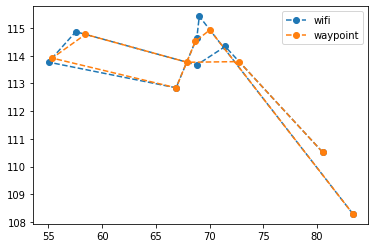

In [28]:
# 線形補完の例
path = test_df['path'].unique()[23]  #15
df = test_df[test_df['path']==path]

waypoint = wifi_waypoint_by_linear_interpolation(
    observed_timestamp=df['wifi_timestamp'].astype(int).values, 
    observed_x=df['x'].values,
    observed_y=df['y'].values, 
    target_timestamp=df['timestamp'].astype(int).values
    )
print(len(df), len(waypoint))

import matplotlib.pyplot as plt
# print(df["timestamp"].astype(int) - df["timestamp"].astype(int).values[0])
plt.plot(df["x"].values, df["y"].values, ls='--', marker="o", label='wifi')
plt.plot(waypoint[:,0], waypoint[:,1], ls='--', marker="o", label='waypoint')
plt.legend()

In [29]:
# 線形補完でwaypointを修正
waypoint_dfs = []
for path,df in test_df.groupby('path'):  #15
    tmp_waypoint = wifi_waypoint_by_linear_interpolation(
        observed_timestamp=df['wifi_timestamp'].astype(int).values, 
        observed_x=df['x'].values,
        observed_y=df['y'].values, 
        target_timestamp=df['timestamp'].astype(int).values
        )
    df['_x'] = tmp_waypoint[:,0]
    df['_y'] = tmp_waypoint[:,1]
    waypoint_dfs.append(df)

waypoint_df = pd.concat(waypoint_dfs).reset_index(drop=True)
waypoint_df

,ssid_0,ssid_1,ssid_2,ssid_3,ssid_4,ssid_5,ssid_6,ssid_7,ssid_8,ssid_9,...,path,site_id,timediff,site_path_timestamp,floor,x,y,wifi_timestamp,_x,_y
0,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,a4e38996343460efde1140975529e97c9f9aa60b,d0af9d9c2709796ee07a0432de0e26298a64e3e8,a4e38996343460efde1140975529e97c9f9aa60b,da39a3ee5e6b4b0d3255bfef95601890afd80709,208255716aecce985d8f7a2bb8117b4dee2d53c5,da39a3ee5e6b4b0d3255bfef95601890afd80709,07b466ea3782f19a25830149eb173cfc5c049246,da39a3ee5e6b4b0d3255bfef95601890afd80709,...,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547,-1170,5da1389e4db8ce0c98bd0547_00ff0c9a71cc37a2ebdd0...,3,70.264259,85.552643,1573190311876,70.264259,85.552643
1,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,d0af9d9c2709796ee07a0432de0e26298a64e3e8,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,da39a3ee5e6b4b0d3255bfef95601890afd80709,a4e38996343460efde1140975529e97c9f9aa60b,208255716aecce985d8f7a2bb8117b4dee2d53c5,a4e38996343460efde1140975529e97c9f9aa60b,da39a3ee5e6b4b0d3255bfef95601890afd80709,07b466ea3782f19a25830149eb173cfc5c049246,25055861b712f167ba58320e846a4aa70f811204,...,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547,-876,5da1389e4db8ce0c98bd0547_00ff0c9a71cc37a2ebdd0...,3,72.831993,85.331207,1573190315620,72.190060,85.386566
2,d0af9d9c2709796ee07a0432de0e26298a64e3e8,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,f2921f9fa47c704da162c06fc348a98e83464d71,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,da39a3ee5e6b4b0d3255bfef95601890afd80709,a4e38996343460efde1140975529e97c9f9aa60b,a4e38996343460efde1140975529e97c9f9aa60b,208255716aecce985d8f7a2bb8117b4dee2d53c5,25055861b712f167ba58320e846a4aa70f811204,f2921f9fa47c704da162c06fc348a98e83464d71,...,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547,73,5da1389e4db8ce0c98bd0547_00ff0c9a71cc37a2ebdd0...,3,70.682457,85.916183,1573190323149,70.682457,85.916183
3,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,a4e38996343460efde1140975529e97c9f9aa60b,f2921f9fa47c704da162c06fc348a98e83464d71,da39a3ee5e6b4b0d3255bfef95601890afd80709,d0af9d9c2709796ee07a0432de0e26298a64e3e8,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,a4e38996343460efde1140975529e97c9f9aa60b,208255716aecce985d8f7a2bb8117b4dee2d53c5,da39a3ee5e6b4b0d3255bfef95601890afd80709,07b466ea3782f19a25830149eb173cfc5c049246,...,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547,-118,5da1389e4db8ce0c98bd0547_00ff0c9a71cc37a2ebdd0...,3,63.739193,84.579300,1573190336356,63.739193,84.579300
4,3c1e7602176e050694e3a5cf8ba5f6f725e3ec51,d0af9d9c2709796ee07a0432de0e26298a64e3e8,5c072340f8e500f7e62819ab82bb8998ecd0ef4e,da39a3ee5e6b4b0d3255bfef95601890afd80709,208255716aecce985d8f7a2bb8117b4dee2d53c5,f2921f9fa47c704da162c06fc348a98e83464d71,a4e38996343460efde1140975529e97c9f9aa60b,a4e38996343460efde1140975529e97c9f9aa60b,da39a3ee5e6b4b0d3255bfef95601890afd80709,f2921f9fa47c704da162c06fc348a98e83464d71,...,00ff0c9a71cc37a2ebdd0f05,5da1389e4db8ce0c98bd0547,75,5da1389e4db8ce0c98bd0547_00ff0c9a71cc37a2ebdd0...,3,68.372520,83.259331,1573190347755,68.372520,83.259331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10128,45671173620a277ceda4ed5411413875dc4cddd0,45671173620a277ceda4ed5411413875dc4cddd0,94c9c12f67502bf93f4ced30194b269d9cec6f92,f0de7db5c2e4bf6c27f0f0b941a941cdc95ac6c5,f44fa6118fed7198296c8b45b2f2684903d99620,c3d209856c667232ef40c1ccb86cfde3a023920c,b7e6027447eb1f81327d66cfd3adbe557aabf26c,8ece1ee8e83b5c2be32750c273a7c0b5f04f72ac,2e40049edd5106db3965286eb2446f3c14b46180,1e15285cc1ee6dd5a2700abfcd0c94d3783f41be,...,ffcd9524c80c0fa5bb859eaf,5a0546857ecc773753327266,-83,5a0546857ecc773753327266_ffcd9524c80c0fa5bb859...,-1,134.895905,180.629761,1578465350337,134.895905,180.629761
10129,45671173620a277ceda4ed5411413875dc4cddd0,45671173620a277ceda4ed5411413875dc4cddd0,94c9c12f67502bf93f4ced30194b269d9cec6f92,b7e6027447eb1f81327d66cfd3adbe557aabf26c,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,b9f0208be00bd8b337be7f12e02e3a3ce846e22b,193453b4b2ad6268a8c6e40c0064fbf1310a6460,8ece

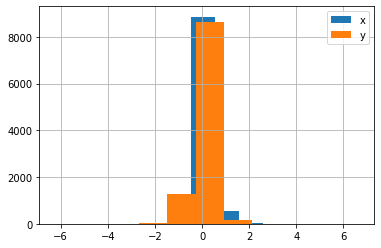

In [30]:
import matplotlib.pyplot as plt
(waypoint_df['x'] - waypoint_df['_x']).hist(label='x')
(waypoint_df['y'] - waypoint_df['_y']).hist(label='y')
plt.legend()

In [31]:
sub = sub.merge(waypoint_df[['site_path_timestamp', '_x', '_y']], on='site_path_timestamp').set_index('site_path_timestamp')
sub = sub.drop(['x','y'], axis=1).rename(columns={'_x':'x', '_y':'y'})
sub

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,89.414192,103.453453
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,84.279193,102.677389
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,85.278405,105.318287
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,86.549147,107.394623
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,85.572413,106.363003
...,...,...,...
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000082589,5,213.603394,96.321754
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000085758,5,211.840591,97.647026
5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f412_0000000090895,5,207.706710,104.344074


In [32]:
sub.to_csv(EXP_NAME + '_sub.csv')

## 後処理

## cost minimaization

In [33]:
import multiprocessing
import scipy.interpolate
import scipy.sparse
from tqdm import tqdm
import sys
sys.path.append('../../')
from src.io_f import read_data_file
from src import compute_f
from scipy.signal import butter, lfilter

In [34]:
import math

order = 3
fs = 50.0  # sample rate, Hz
# fs = 100
# cutoff = 3.667  # desired cutoff frequency of the filter, Hz
cutoff = 3

step_distance = 0.8
w_height = 1.7
m_trans = -5

In [35]:
def compute_rel_positions(acce_datas, ahrs_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_f.compute_steps(acce_datas)
    headings = compute_f.compute_headings(ahrs_datas)
    stride_lengths = compute_f.compute_stride_length(step_acce_max_mins)
    step_headings = compute_f.compute_step_heading(step_timestamps, headings)
    rel_positions = compute_f.compute_rel_positions(stride_lengths, step_headings)
    return rel_positions


def correct_path(args):
    path, path_df = args
    
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    example = read_data_file(root_dir/ f'indoor-location-navigation/test/{path}.txt')
    
    # rel_positions = compute_rel_positions(example.acce, example.ahrs)
    # ↑を↓に置き換える
    rel_positions1 = compute_rel_positions(example.acce, example.ahrs)
    rel_positions2 = steps_compute_rel_positions(example)
    rel1 = rel_positions1.copy()
    rel2 = rel_positions2.copy()
    rel1[:,1:] = rel_positions1[:,1:] / 2
    rel2[:,1:] = rel_positions2[:,1:] / 2
    rel_positions = np.vstack([rel1,rel2])
    rel_positions = rel_positions[np.argsort(rel_positions[:, 0])]
    
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]
    delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)

    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })



def correct_path_train(args):
    #print(args)
    (site_id, path, floor), path_df = args
    
    T_ref  = path_df['timestamp'].values
    xy_hat = path_df[['x', 'y']].values
    
    example = read_data_file(f'{root_dir}/indoor-location-navigation/train/{site_id}/{floor}/{path}.txt')
    
    # rel_positions = compute_rel_positions(example.acce, example.ahrs)
    # ↑を↓に置き換える
    rel_positions1 = compute_rel_positions(example.acce, example.ahrs)
    rel_positions2 = steps_compute_rel_positions(example)
    rel1 = rel_positions1.copy()
    rel2 = rel_positions2.copy()
    rel1[:,1:] = rel_positions1[:,1:] / 2
    rel2[:,1:] = rel_positions2[:,1:] / 2
    rel_positions = np.vstack([rel1,rel2])
    rel_positions = rel_positions[np.argsort(rel_positions[:, 0])]
    
    
    if T_ref[-1] > rel_positions[-1, 0]:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions, np.array([[T_ref[-1], 0, 0]])]
    else:
        rel_positions = [np.array([[0, 0, 0]]), rel_positions]
    rel_positions = np.concatenate(rel_positions)
    
    T_rel = rel_positions[:, 0]

    try:
        delta_xy_hat = np.diff(scipy.interpolate.interp1d(T_rel, np.cumsum(rel_positions[:, 1:3], axis=0), axis=0)(T_ref), axis=0)
    except:
        return pd.DataFrame({
            'site_path_timestamp' : path_df['site_path_timestamp'],
            'floor' : path_df['floor'],
            'x' : path_df['x'].to_numpy(),
            'y' : path_df['y'].to_numpy()
        })
    

    N = xy_hat.shape[0]
    delta_t = np.diff(T_ref)
    alpha = (8.1)**(-2) * np.ones(N)
    beta  = (0.3 + 0.3 * 1e-3 * delta_t)**(-2)
    A = scipy.sparse.spdiags(alpha, [0], N, N)
    B = scipy.sparse.spdiags( beta, [0], N-1, N-1)
    D = scipy.sparse.spdiags(np.stack([-np.ones(N), np.ones(N)]), [0, 1], N-1, N)

    Q = A + (D.T @ B @ D)
    c = (A @ xy_hat) + (D.T @ (B @ delta_xy_hat))
    xy_star = scipy.sparse.linalg.spsolve(Q, c)


    return pd.DataFrame({
        'site_path_timestamp' : path_df['site_path_timestamp'],
        'floor' : path_df['floor'],
        'x' : xy_star[:, 0],
        'y' : xy_star[:, 1],
    })



def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def peak_accel_threshold(data, timestamps, threshold):
    d_acc = []
    last_state = 'below'
    crest_troughs = 0
    crossings = []

    for i, datum in enumerate(data):
        
        current_state = last_state
        if datum < threshold:
            current_state = 'below'
        elif datum > threshold:
            current_state = 'above'

        if current_state is not last_state:
            if current_state is 'above':
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)
            else:
                crossing = [timestamps[i], threshold]
                crossings.append(crossing)

            crest_troughs += 1
        last_state = current_state
    return np.array(crossings)


<>:146: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:146: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-35-a1a172f865b0>:146: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if current_state is 'above':


In [36]:
def steps_compute_rel_positions(sample_file):
    
    mix_acce = np.sqrt(sample_file.acce[:,1:2]**2 + sample_file.acce[:,2:3]**2 + sample_file.acce[:,3:4]**2)
    mix_acce = np.concatenate([sample_file.acce[:,0:1], mix_acce], 1)
    mix_df = pd.DataFrame(mix_acce)
    mix_df.columns = ["timestamp","acce"]
    
    filtered = butter_lowpass_filter(mix_df["acce"], cutoff, fs, order)

    threshold = filtered.mean() * 1.1
    crossings = peak_accel_threshold(filtered, mix_df["timestamp"], threshold)

    step_sum = len(crossings)/2
    distance = w_height * 0.4 * step_sum

    mag_df = pd.DataFrame(sample_file.magn)
    mag_df.columns = ["timestamp","x","y","z"]
    
    acce_df = pd.DataFrame(sample_file.acce)
    acce_df.columns = ["timestamp","ax","ay","az"]
    
    mag_df = pd.merge(mag_df,acce_df,on="timestamp")
    mag_df.dropna()
    
    time_di_list = []

    for i in mag_df.iterrows():

        gx,gy,gz = i[1][1],i[1][2],i[1][3]
        ax,ay,az = i[1][4],i[1][5],i[1][6]

        roll = math.atan2(ay,az)
        pitch = math.atan2(-1*ax , (ay * math.sin(roll) + az * math.cos(roll)))

        q = m_trans - math.degrees(math.atan2(
            (gz*math.sin(roll)-gy*math.cos(roll)),(gx*math.cos(pitch) + gy*math.sin(roll)*math.sin(pitch) + gz*math.sin(pitch)*math.cos(roll))
        )) -90
        if q <= 0:
            q += 360
        time_di_list.append((i[1][0],q))

    d_list = [x[1] for x in time_di_list]
    
    steps = []
    step_time = []
    di_dict = dict(time_di_list)

    for n,i in enumerate(crossings[:,:1]):
        if n % 2 == 1:
            continue
        direct_now = di_dict[i[0]]
        dx = math.sin(math.radians(direct_now))
        dy = math.cos(math.radians(direct_now))
#         print(int(n/2+1),"歩目/x:",dx,"/y:",dy,"/角度：",direct_now)
        steps.append((i[0],dx,dy))
        step_time.append(i[0])
    
        step_dtime = np.diff(step_time)/1000
        step_dtime = step_dtime.tolist()
        step_dtime.insert(0,5)
        
        rel_position = []

        wp_idx = 0
#         print("WP:",round(sample_file.waypoint[0,1],3),round(sample_file.waypoint[0,2],3),sample_file.waypoint[0,0])
#         print("------------------")
        for p,i in enumerate(steps):
            step_distance = 0
            if step_dtime[p] >= 1:
                step_distance = w_height*0.25
            elif step_dtime[p] >= 0.75:
                step_distance = w_height*0.3
            elif step_dtime[p] >= 0.5:
                step_distance = w_height*0.4
            elif step_dtime[p] >= 0.35:
                step_distance = w_height*0.45
            elif step_dtime[p] >= 0.2:
                step_distance = w_height*0.5
            else:
                step_distance = w_height*0.4

#             step_x += i[1]*step_distance
#             step_y += i[2]*step_distance
            
            rel_position.append([i[0], i[1]*step_distance, i[2]*step_distance])
#     print(rel_position)
    
    return np.array(rel_position)

In [37]:
%%time

oofs_df = oofs_df.rename(columns={'x':'target_x', 'y':'target_y', 'oof_x':'x', 'oof_y':'y'})
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path_train, oofs_df.groupby(['site_id_str', 'path', 'floor_str']))
    dfs = tqdm(dfs)
    dfs = list(dfs)

oof_post_process = pd.concat(dfs).sort_index()
oofs_df['oof_min_x'] = oof_post_process['x']
oofs_df['oof_min_y'] = oof_post_process['y']

# 元に戻す
oofs_df = oofs_df.rename(columns={'x':'oof_x', 'y':'oof_y'})
oofs_df

10836it [05:26, 33.18it/s]
CPU times: user 53.8 s, sys: 12 s, total: 1min 5s
Wall time: 5min 31s


,timestamp,target_x,target_y,floor,ix,iy,floor_str,path,site_id,site_id_str,oof_x,oof_y,oof_floor,site_path_timestamp,oof_min_x,oof_min_y
0,1561368762838,78.218193,38.999737,2.0,77.843651,37.382805,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,78.898567,39.335052,0.000000,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,82.634249,38.080288
1,1561368762838,78.218193,38.999737,2.0,77.562737,36.170105,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,81.260681,33.549149,0.000000,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,82.639374,38.078567
2,1561368774057,76.251839,30.510839,2.0,76.308945,29.970827,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,82.527695,30.896685,0.000000,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,84.219459,28.766186
3,1561368774057,76.251839,30.510839,2.0,77.222664,21.330624,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,80.717308,28.906256,0.000000,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,84.228795,28.767755
4,1561368774057,76.251839,30.510839,2.0,76.994240,23.490675,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,79.884903,26.587894,0.000000,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,84.242948,28.769135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256744,1574420742502,193.204880,108.001518,-1.0,195.845032,107.961899,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,201.334671,105.369644,0.433354,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,200.988469,104.478296
256745,1574420742502,193.204880,108.001518,-1.0,197.957138,107.930206,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,198.972198,106.005524,0.426785,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,200.965273,104.478859
256746,1574420753754,204.293488,107.835121,-1.0,201.653351,107.874741,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,201.797028,106.997734,0.436648,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,207.418033,106.597045
256747,1574420753754,204.293488,107.835121,-1.0,203.237427,107.850967,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,202.778946,105.169876,0.437685,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,207.405281,106.594964


In [38]:
# waypoint補正前のx,yでの評価
oof_score_post_process = mean_position_error(
    oofs_df['oof_min_x'], oofs_df['oof_min_y'], 0, 
    oofs_df['target_x'], oofs_df['target_y'], 0
    )
wandb_config['CV_cost'] = oof_score_post_process
print(f"(after cost-min) CV:{oof_score_post_process}")

(after cost-min) CV:5.884450732232381


In [39]:
# waypoint補正後のx,yでの評価
oof_score_post_process = mean_position_error(
    oofs_df['oof_min_x'], oofs_df['oof_min_y'], 0, 
    oofs_df['ix'], oofs_df['iy'], 0
    )
wandb_config['iCV_cost'] = oof_score_post_process
print(f"(after cost-min) CV:{oof_score_post_process}")

(after cost-min) CV:6.098522357181695


In [40]:
sub = sub.reset_index()
sub_org = sub.copy()
tmp = sub['site_path_timestamp'].apply(lambda s : pd.Series(s.split('_')))
sub['site'] = tmp[0]
sub['path'] = tmp[1]
sub['timestamp'] = tmp[2].astype(float)
sub

,site_path_timestamp,floor,x,y,site,path,timestamp
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,89.414192,103.453453,5a0546857ecc773753327266,046cfa46be49fc10834815c6,9.0
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,84.279193,102.677389,5a0546857ecc773753327266,046cfa46be49fc10834815c6,9017.0
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.278405,105.318287,5a0546857ecc773753327266,046cfa46be49fc10834815c6,15326.0
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,86.549147,107.394623,5a0546857ecc773753327266,046cfa46be49fc10834815c6,18763.0
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.572413,106.363003,5a0546857ecc773753327266,046cfa46be49fc10834815c6,22328.0
...,...,...,...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,213.603394,96.321754,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,82589.0
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,211.840591,97.647026,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,85758.0
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,207.706710,104.344074,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,90895.0
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,202.666625,108.342581,5dc8cea7659e181adb076a3f,fd64de8c4a2fc5ebb0e9f412,96899.0


In [41]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(correct_path, sub.groupby(['path']))
    dfs = tqdm(dfs)
    dfs = list(dfs)
new_sub = pd.concat(dfs).sort_values('site_path_timestamp')
new_sub

626it [00:52, 11.99it/s]


,site_path_timestamp,floor,x,y
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,91.632362,97.181883
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,82.176305,99.665940
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,83.859428,104.736352
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,84.657936,108.497594
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.131612,112.203910
...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,211.268879,97.280202
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,209.452379,100.683084
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,205.651771,106.417728
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,198.466589,110.829686


In [42]:
new_sub.to_csv(RUN_NAME + '_cost_sub.csv', index=False)

## snap to grid

In [43]:
from scipy.spatial.distance import cdist
def sub_process(sub, train_waypoints):
    train_waypoints['isTrainWaypoint'] = True
    sub = split_col(sub[['site_path_timestamp','floor','x','y']]).copy()
    sub = sub.merge(train_waypoints[['site','floorNo','floor']].drop_duplicates(), how='left')
    sub = sub.merge(
        train_waypoints[['x','y','site','floor','isTrainWaypoint']].drop_duplicates(),
        how='left',
        on=['site','x','y','floor']
             )
    sub['isTrainWaypoint'] = sub['isTrainWaypoint'].fillna(False)
    return sub.copy()

def split_col(df):
    df = pd.concat([
        df['site_path_timestamp'].str.split('_', expand=True) \
        .rename(columns={0:'site',
                         1:'path',
                         2:'timestamp'}),
        df
    ], axis=1).copy()
    return df

floor_map = {"B2":-2, "B1":-1, "F1":0, "F2": 1, "F3":2,
             "F4":3, "F5":4, "F6":5, "F7":6,"F8":7,"F9":8,
             "1F":0, "2F":1, "3F":2, "4F":3, "5F":4, "6F":5,
             "7F":6, "8F": 7, "9F":8}

def add_xy(df):
    df['xy'] = [(x, y) for x,y in zip(df['x'], df['y'])]
    return df

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

def snap_to_grid(sub, threshold):
    """
    Snap to grid if within a threshold.
    
    x, y are the predicted points.
    x_, y_ are the closest grid points.
    _x_, _y_ are the new predictions after post processing.
    """
    sub['_x_'] = sub['x']
    sub['_y_'] = sub['y']
    sub.loc[sub['dist'] < threshold, '_x_'] = sub.loc[sub['dist'] < threshold]['x_']
    sub.loc[sub['dist'] < threshold, '_y_'] = sub.loc[sub['dist'] < threshold]['y_']
    return sub.copy()


In [44]:

oofs_df

,timestamp,target_x,target_y,floor,ix,iy,floor_str,path,site_id,site_id_str,oof_x,oof_y,oof_floor,site_path_timestamp,oof_min_x,oof_min_y
0,1561368762838,78.218193,38.999737,2.0,77.843651,37.382805,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,78.898567,39.335052,0.000000,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,82.634249,38.080288
1,1561368762838,78.218193,38.999737,2.0,77.562737,36.170105,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,81.260681,33.549149,0.000000,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,82.639374,38.078567
2,1561368774057,76.251839,30.510839,2.0,76.308945,29.970827,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,82.527695,30.896685,0.000000,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,84.219459,28.766186
3,1561368774057,76.251839,30.510839,2.0,77.222664,21.330624,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,80.717308,28.906256,0.000000,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,84.228795,28.767755
4,1561368774057,76.251839,30.510839,2.0,76.994240,23.490675,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,79.884903,26.587894,0.000000,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,84.242948,28.769135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256744,1574420742502,193.204880,108.001518,-1.0,195.845032,107.961899,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,201.334671,105.369644,0.433354,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,200.988469,104.478296
256745,1574420742502,193.204880,108.001518,-1.0,197.957138,107.930206,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,198.972198,106.005524,0.426785,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,200.965273,104.478859
256746,1574420753754,204.293488,107.835121,-1.0,201.653351,107.874741,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,201.797028,106.997734,0.436648,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,207.418033,106.597045
256747,1574420753754,204.293488,107.835121,-1.0,203.237427,107.850967,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,202.778946,105.169876,0.437685,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,207.405281,106.594964


In [45]:
train_waypoints = pd.read_csv('../../input/indoor-location-train-waypoints/train_waypoints.csv')
# 線形補完しているwaypointをtrain_waypoints（grid）とする。gridを増やすのが狙い。
# train_waypoints = oofs_df[['oof_x', 'oof_y', 'timestamp', 'site_id_str', 'floor', 'floor_str', 'path']]
# train_waypoints = train_waypoints.rename(columns={'oof_x':'x', 'oof_y':"y", 'site_id_str':"site", 'floor_str':'floorNo'})

snap_df = oofs_df[['site_path_timestamp','floor','oof_min_x','oof_min_y']].copy()
snap_df = snap_df.rename(columns={'oof_min_x':'x', 'oof_min_y':'y'})
snap_df = sub_process(snap_df, train_waypoints)
snap_df = add_xy(snap_df)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in tqdm(snap_df.groupby(['site','floor'])):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['oof_min_snap_x'] = d['matched_point'].apply(lambda x: x[0])
    d['oof_min_snap_y'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

# 上書き
snap_df = pd.concat(ds).sort_index()
snap_df

100%|██████████| 139/139 [01:39<00:00,  1.39it/s]


,site,path,timestamp,site_path_timestamp,floor,x,y,floorNo,isTrainWaypoint,xy,matched_point,oof_min_snap_x,oof_min_snap_y
0,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368762838,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,2.0,82.634249,38.080288,F3,False,"(82.6342491170629, 38.08028809453274)","(80.6814, 39.265667)",80.68140,39.265667
1,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368762838,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,2.0,82.639374,38.078567,F3,False,"(82.63937350926777, 38.07856688136991)","(80.6814, 39.265667)",80.68140,39.265667
2,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368774057,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,2.0,84.219459,28.766186,F3,False,"(84.21945875223538, 28.766185968669767)","(84.22669, 27.13862)",84.22669,27.138620
3,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368774057,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,2.0,84.228795,28.767755,F3,False,"(84.22879501879828, 28.76775545460688)","(84.22669, 27.13862)",84.22669,27.138620
4,5a0546857ecc773753327266,5d10a1669c50c70008fe8977,1561368774057,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,2.0,84.242948,28.769135,F3,False,"(84.24294813992137, 28.769134953894568)","(84.22669, 27.13862)",84.22669,27.138620
...,...,...,...,...,...,...,...,...,...,...,...,...,...
256744,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,1574420742502,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,-1.0,200.988469,104.478296,B1,False,"(200.98846939181684, 104.47829590601565)","(200.75478, 106.75563)",200.75478,106.755630
256745,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,1574420742502,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,-1.0,200.965273,104.478859,B1,False,"(200.96527340355962, 104.4788588723147)","(200.75478, 106.75563)",200.75478,106.755630
256746,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,1574420753754,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,-1.0,207.418033,106.597045,B1,False,"(207.41803269657245, 106.59704525118721)","(208.15857, 104.7078)",208.15857,104.707800
256747,5dc8cea7659e181adb076a3f,5dd7c119c5b77e0006b16b99,1574420753754,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,-1.0,207.405281,106.594964,B1,False,"(207.40528126253457, 106.59496438534912)","(208.15857, 104.7078)",208.15857,104.707800


In [46]:
oofs_df['oof_min_snap_x'] = snap_df['oof_min_snap_x']
oofs_df['oof_min_snap_y'] = snap_df['oof_min_snap_y']
oofs_df

,timestamp,target_x,target_y,floor,ix,iy,floor_str,path,site_id,site_id_str,oof_x,oof_y,oof_floor,site_path_timestamp,oof_min_x,oof_min_y,oof_min_snap_x,oof_min_snap_y
0,1561368762838,78.218193,38.999737,2.0,77.843651,37.382805,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,78.898567,39.335052,0.000000,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,82.634249,38.080288,80.68140,39.265667
1,1561368762838,78.218193,38.999737,2.0,77.562737,36.170105,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,81.260681,33.549149,0.000000,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,82.639374,38.078567,80.68140,39.265667
2,1561368774057,76.251839,30.510839,2.0,76.308945,29.970827,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,82.527695,30.896685,0.000000,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,84.219459,28.766186,84.22669,27.138620
3,1561368774057,76.251839,30.510839,2.0,77.222664,21.330624,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,80.717308,28.906256,0.000000,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,84.228795,28.767755,84.22669,27.138620
4,1561368774057,76.251839,30.510839,2.0,76.994240,23.490675,F3,5d10a1669c50c70008fe8977,0,5a0546857ecc773753327266,79.884903,26.587894,0.000000,5a0546857ecc773753327266_5d10a1669c50c70008fe8...,84.242948,28.769135,84.22669,27.138620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256744,1574420742502,193.204880,108.001518,-1.0,195.845032,107.961899,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,201.334671,105.369644,0.433354,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,200.988469,104.478296,200.75478,106.755630
256745,1574420742502,193.204880,108.001518,-1.0,197.957138,107.930206,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,198.972198,106.005524,0.426785,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,200.965273,104.478859,200.75478,106.755630
256746,1574420753754,204.293488,107.835121,-1.0,201.653351,107.874741,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,201.797028,106.997734,0.436648,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,207.418033,106.597045,208.15857,104.707800
256747,1574420753754,204.293488,107.835121,-1.0,203.237427,107.850967,B1,5dd7c119c5b77e0006b16b99,23,5dc8cea7659e181adb076a3f,202.778946,105.169876,0.437685,5dc8cea7659e181adb076a3f_5dd7c119c5b77e0006b16...,207.405281,106.594964,208.15857,104.707800


In [47]:
# waypoint補正前のx,yでの評価
oof_score_post_process = mean_position_error(
    oofs_df['oof_min_snap_x'], oofs_df['oof_min_snap_y'], 0, 
    oofs_df['target_x'], oofs_df['target_y'], 0
    )
wandb_config['CV_cost_snap'] = oof_score_post_process
print(f"(after cost-min + snap) CV:{oof_score_post_process}")

(after cost-min + snap) CV:5.385620594586939


In [48]:
# waypoint補正前のx,yでの評価
oof_score_post_process = mean_position_error(
    oofs_df['oof_min_snap_x'], oofs_df['oof_min_snap_y'], 0, 
    oofs_df['ix'], oofs_df['iy'], 0
    )
wandb_config['iCV_cost_snap'] = oof_score_post_process
print(f"(after cost-min + snap) CV:{oof_score_post_process}")

(after cost-min + snap) CV:6.014751540767926


In [49]:
# x_pred = oofs_df["oof_min_snap_x"]
# y_pred = oofs_df["oof_min_snap_y"]
# f_pred = oofs_df["floor"]  # 正解を与える
# x_true = oofs_df["wifi_x"]
# y_true = oofs_df["wifi_y"]
# f_true = oofs_df["floor"]
# site_arr = oofs_df["site_id_str"]
# df_result_site3 = calc_metrics_site(x_pred, y_pred, f_pred, x_true, y_true, f_true, site_arr)
# df_result_site3.style.bar(subset=['n_sample', 'score'], color=['teal'])

In [50]:
# site_eval_report(df_result_site3)

In [51]:
# train_waypoints = pd.read_csv('../../input/indoor-location-train-waypoints/train_waypoints.csv')

new_sub = sub_process(new_sub, train_waypoints)
new_sub = add_xy(new_sub)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in new_sub.groupby(['site','floor']):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floor'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

new_sub2 = pd.concat(ds)

In [52]:
new_sub2 = new_sub2[['site_path_timestamp','floor','x_','y_']].sort_index()
new_sub2 = new_sub2.rename(columns={'x_':'x', 'y_':'y'})
new_sub2

,site_path_timestamp,floor,x,y
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,93.72847,97.948860
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,85.36019,99.075780
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,87.16283,104.450550
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,81.65774,110.509090
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,0,81.65774,110.509090
...,...,...,...,...
10128,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,215.26227,97.973610
10129,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,206.62791,102.635210
10130,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,205.51130,107.841324
10131,5dc8cea7659e181adb076a3f_fd64de8c4a2fc5ebb0e9f...,5,195.82588,109.711815


In [53]:
new_sub2.to_csv(RUN_NAME + '_cost_snap_sub.csv', index=False)

In [54]:
# import matplotlib.pyplot as plt
# df_result_site1['score'].plot(label='oof')
# df_result_site2['score'].plot(label='cost')
# df_result_site3['score'].plot(label='cost+snap')
# plt.legend()
# plt.grid()
# plt.savefig('site_result.png')

In [55]:
wandb.finish()